In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam

import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Reshape, LSTM
from keras import backend as K
import itertools
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
for dirname, _, filenames in os.walk('E:\BACKUP\C_drive\Skin_Cancer\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_metadata.csv
E:\BACKUP\C_drive\Skin_Cancer\input\hmnist_28_28_L.csv
E:\BACKUP\C_drive\Skin_Cancer\input\hmnist_28_28_RGB.csv
E:\BACKUP\C_drive\Skin_Cancer\input\hmnist_8_8_L.csv
E:\BACKUP\C_drive\Skin_Cancer\input\hmnist_8_8_RGB.csv
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024306.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024307.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024308.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024309.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024310.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024311.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024312.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024313.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HAM10000_images_part_1\ISIC_0024314.jpg
E:\BACKUP\C_drive\Skin_Cancer\input\HA

In [3]:
base_skin_dir = os.path.join('..', 'Skin_Cancer\input')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv('input/HAM10000_metadata.csv')
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
5709,HAM_0005577,ISIC_0028320,nv,follow_up,40.0,male,trunk,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Melanocytic nevi,4
5002,HAM_0006783,ISIC_0025624,nv,follow_up,55.0,male,trunk,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Melanocytic nevi,4
1000,HAM_0004309,ISIC_0028681,bkl,consensus,70.0,female,trunk,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
5521,HAM_0004136,ISIC_0029787,nv,follow_up,55.0,male,back,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Melanocytic nevi,4
5964,HAM_0001602,ISIC_0032458,nv,follow_up,55.0,male,trunk,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Melanocytic nevi,4
386,HAM_0004491,ISIC_0028846,bkl,histo,45.0,male,face,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
5357,HAM_0006565,ISIC_0027489,nv,follow_up,80.0,male,trunk,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Melanocytic nevi,4
924,HAM_0004142,ISIC_0033260,bkl,consensus,80.0,male,trunk,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,2
1173,HAM_0000349,ISIC_0033695,df,consensus,45.0,female,lower extremity,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Dermatofibroma,3
9074,HAM_0005848,ISIC_0030553,nv,histo,50.0,male,abdomen,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Melanocytic nevi,4


In [6]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [7]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))


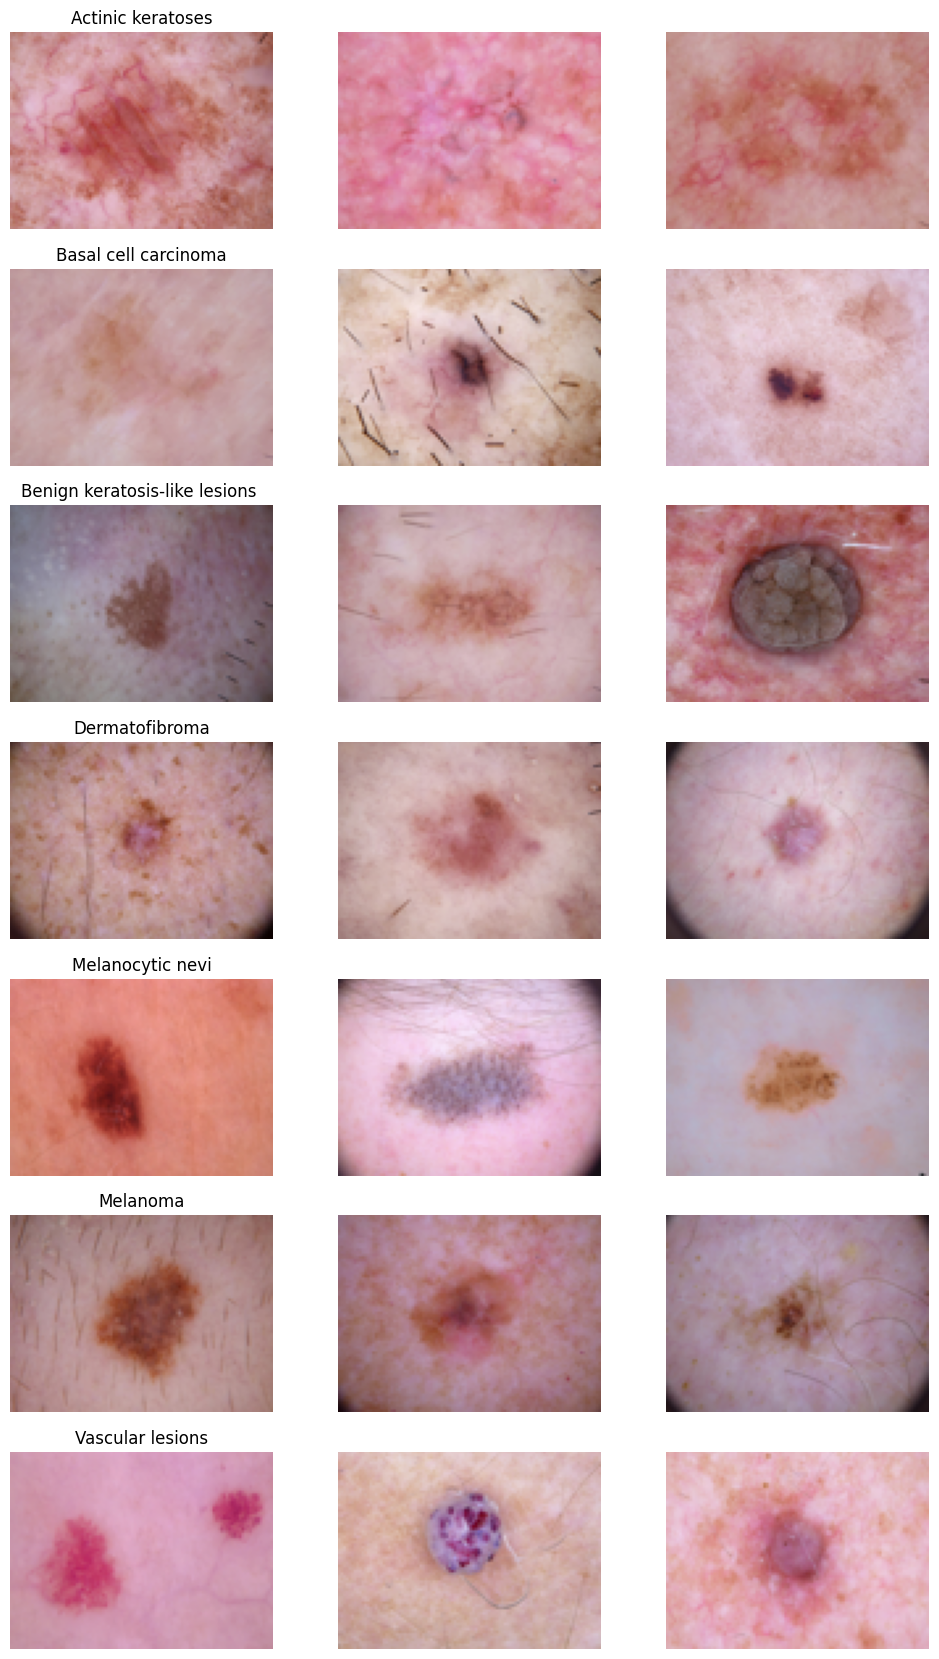

In [8]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [9]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [10]:
features

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,..\Skin_Cancer\input\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Actinic keratoses,"[[[155, 137, 148], [154, 136, 147], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Actinic keratoses,"[[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Actinic keratoses,"[[[112, 102, 105], [127, 116, 117], [141, 127,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,..\Skin_Cancer\input\HAM10000_images_part_2\IS...,Actinic keratoses,"[[[158, 122, 146], [159, 122, 141], [154, 112,..."


In [11]:
target

0        2
1        2
2        2
3        2
4        2
        ..
10010    0
10011    0
10012    0
10013    0
10014    5
Name: cell_type_idx, Length: 10015, dtype: int8

In [12]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=23)

In [13]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [14]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [15]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 23)

In [16]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(x_train)

In [18]:
input_shape = (75, 100, 3)
num_classes = 7
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes,activation = 'softmax'))

In [38]:
from tensorflow.keras.optimizers.legacy import Adam

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/10, amsgrad=False)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


D:\python_3.10\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 64)       1792      
                                                                 
 batch_normalization (BatchN  (None, 75, 100, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 64)       36928     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 100, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 64)       0         
 )                                                               
                                                        

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=6)
mod_chckpt = ModelCheckpoint(filepath='model_v1_rms.h5', monitor='val_loss', save_best_only=True)

In [42]:
epochs = 10
batch_size = 50

history= model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (x_validate,y_validate),
                                verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

Epoch 1/10
144/144 [==============================] - 457s 3s/step - loss: 1.3054 - accuracy: 0.6151 - val_loss: 1.4740 - val_accuracy: 0.6658 - lr: 0.0010
Epoch 2/10
144/144 [==============================] - 446s 3s/step - loss: 0.8466 - accuracy: 0.7017 - val_loss: 1.4558 - val_accuracy: 0.6559 - lr: 0.0010
Epoch 3/10
144/144 [==============================] - 431s 3s/step - loss: 0.7630 - accuracy: 0.7228 - val_loss: 0.9931 - val_accuracy: 0.6920 - lr: 0.0010
Epoch 4/10
144/144 [==============================] - 441s 3s/step - loss: 0.7512 - accuracy: 0.7274 - val_loss: 0.7959 - val_accuracy: 0.7170 - lr: 0.0010
Epoch 5/10
144/144 [==============================] - 443s 3s/step - loss: 0.7112 - accuracy: 0.7381 - val_loss: 0.6958 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 6/10
144/144 [==============================] - 446s 3s/step - loss: 0.6873 - accuracy: 0.7458 - val_loss: 0.7505 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 7/10
144/144 [==============================] - 441s 3s/st

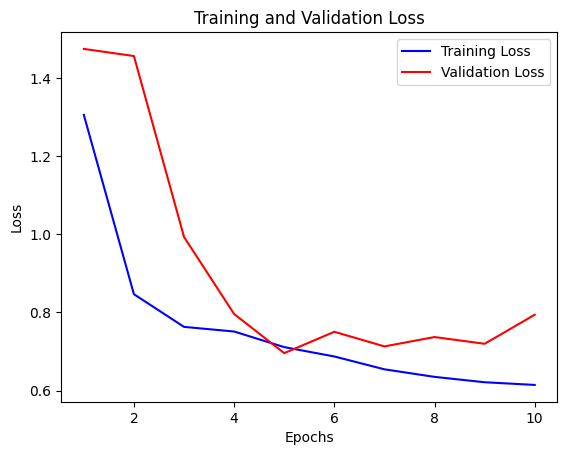

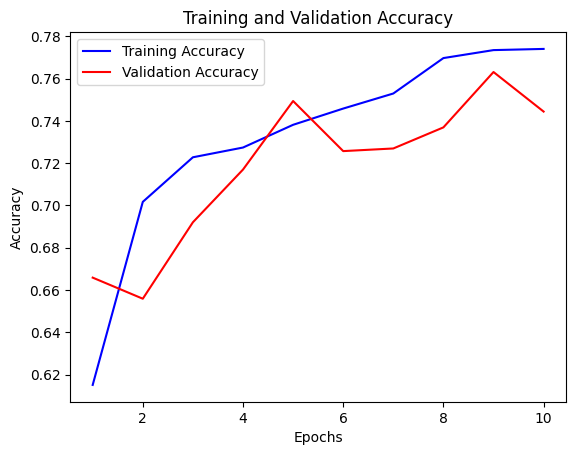

In [43]:
history_dict = history.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_adam.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_adam.png')
plt.show()

In [44]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('adam_model.h5')

26/26 [==============================] - 8s 316ms/step - loss: 0.7941 - accuracy: 0.7444
Validation: accuracy = 0.744389  ;  loss_v = 0.794087
Test: accuracy = 0.748377  ;  loss = 0.747250


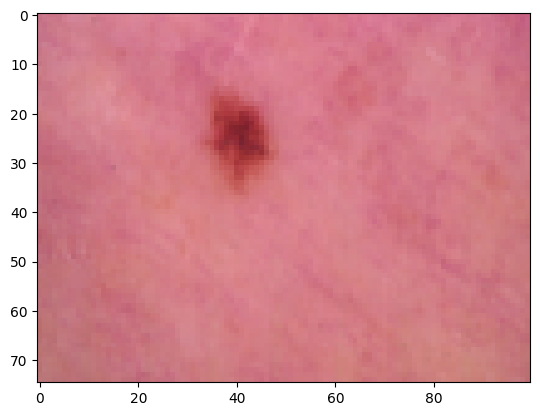

In [45]:
plt.imshow(((x_test[5]*x_test_std)+x_test_mean).astype('int'))

26/26 [==============================] - 10s 327ms/step


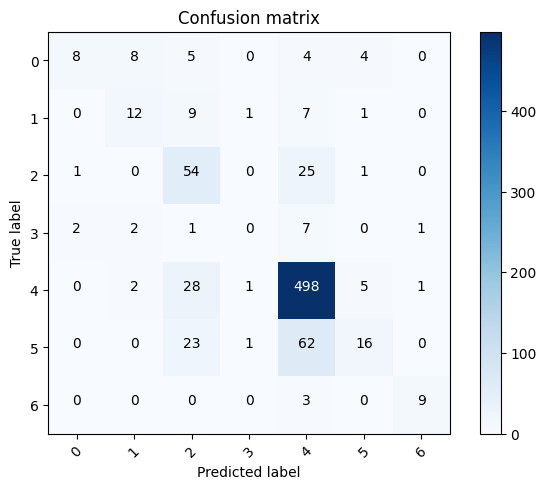

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

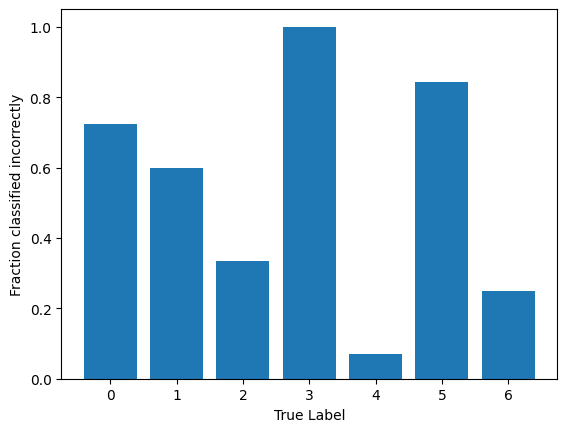

In [47]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

##### CNN + LSTM model

In [48]:
model2 = Sequential()
model2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',))
model2.add(BatchNormalization())
model2.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Flatten())
model2.add(Reshape((9*16,192)))
model2.add(LSTM(units=32))
model2.add(Dense(64, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dense(num_classes,activation = 'softmax'))

In [49]:
# optimizer2 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model2.compile(optimizer = optimizer2 , loss = "categorical_crossentropy", metrics=["accuracy"])

from tensorflow.keras.optimizers.legacy import Adam

optimizer2 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(optimizer=optimizer2, loss="categorical_crossentropy", metrics=["accuracy"])


In [50]:
epochs = 3
batch_size = 50

history2= model2.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                epochs = epochs, validation_data = (x_validate,y_validate),
                                verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

Epoch 1/3
144/144 [==============================] - 435s 3s/step - loss: 1.4959 - accuracy: 0.5236 - val_loss: 1.2391 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 2/3
144/144 [==============================] - 444s 3s/step - loss: 1.0439 - accuracy: 0.6475 - val_loss: 1.0540 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 3/3
144/144 [==============================] - 452s 3s/step - loss: 0.9913 - accuracy: 0.6689 - val_loss: 1.0354 - val_accuracy: 0.6234 - lr: 0.0010


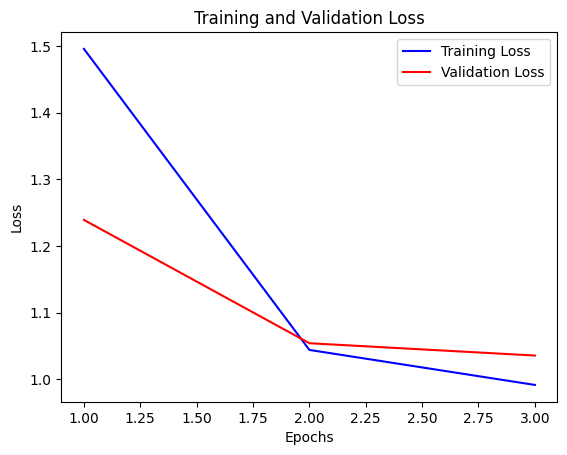

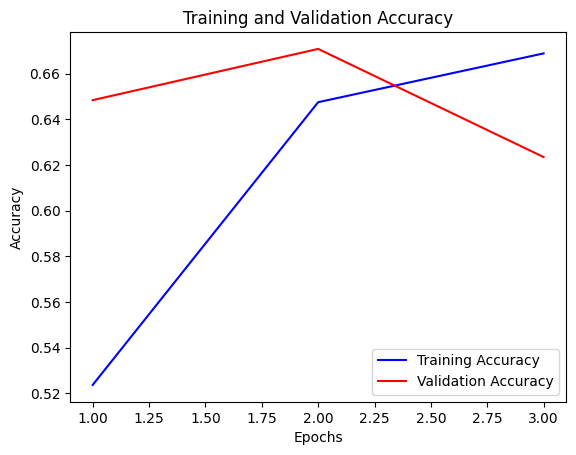

In [51]:
history_dict = history2.history
loss_value = history_dict['loss']
val_loss_value = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(loss_value) + 1)
plt.plot(epochs, loss_value, 'b', label='Training Loss')
plt.plot(epochs, val_loss_value, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_lstm.png')
plt.show()

plt.figure()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('acc_lstm.png')
plt.show()

In [52]:
loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model2.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save('lstm_model.h5')

26/26 [==============================] - 9s 332ms/step - loss: 1.0354 - accuracy: 0.6234
Validation: accuracy = 0.623441  ;  loss_v = 1.035439
Test: accuracy = 0.634548  ;  loss = 1.015697


In [53]:
print(f"Predicted {np.argmax(model2.predict(x_test[1].reshape(-1,75,100,3)))}\nActual {np.argmax(y_test[1])}")

1/1 [==============================] - 1s 1s/step
Predicted 4
Actual 4


In [60]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

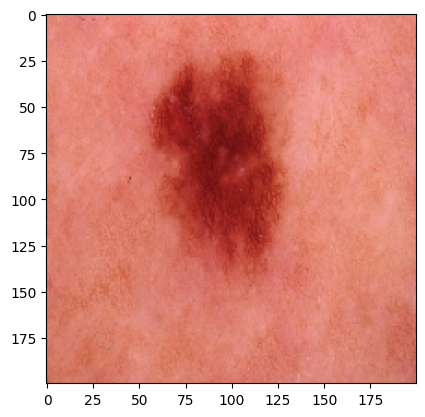

Prediction: Melanocytic nevi


In [61]:

from skimage import io
from keras.preprocessing import image
img = load_img('../Skin_Cancer/input/HAM10000_images_part_1/ISIC_0026899.jpg', grayscale=False, target_size=(64, 64))
show_img=load_img('../Skin_Cancer/input/HAM10000_images_part_1/ISIC_0026899.jpg', grayscale=False, target_size=(200, 200))
disease_class = [ 'Melanocytic nevi','Melanoma','Benign keratosis-like lesions ','Basal cell carcinoma','Actinic keratoses','Vascular lesions','Dermatofibroma']
x = img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255


plt.imshow(show_img)
plt.show()

a=0
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])